## おことわり

この記事は村山裕和氏による記事: https://zenn.dev/takuya_fukatsu/articles/0b9c8df4a51042 を学習するためのメモです

In [1]:
import time
from dataclasses import dataclass

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Circle

In [2]:
# 連続状態方程式
@jax.jit
def model_func(x, u):
    Bk = jnp.array([[jnp.cos(x[2]), 0], [jnp.sin(x[2]), 0], [0, 1]], dtype=jnp.float32)
    x_dot = Bk @ u
    return x_dot

In [3]:
# コントローラーに関するパラメーター
@dataclass
class Cont_Args:
    # コントローラーのパラメータ
    Ts = 0.02  # 制御周期
    tf = 1.0  # 予測ホライズンの最終長さ
    N = 50  # 予測ホライズンの分割数
    # dt = Ts  # 今回は意味の無いパラメータなので無視してください
    alpha = 0.5  # 予測ホライズンを変化させる計算のパラメータ
    zeta = 1  # U_dotを計算する時の係数パラメータ（zetaと書いてますがツェータです）

    # 評価関数中の重み
    # 状態変数の項
    Q = jnp.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=jnp.float32) * 0

    # 制御入力の項
    R = jnp.array([[100, 0], [0, 10]], dtype=jnp.float32)

    # 最終地点の項
    S = jnp.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=jnp.float32) * 100

    # 目標地点
    x_ob = jnp.array([5, 0, 0], dtype=jnp.float32)

    # 目標入力
    u_ob = jnp.array([0, 0], dtype=jnp.float32)

    # 次元データ
    obss_dim = 3  # 状態変数の次元
    action_dim = 2  # 入力変数の次元

    # 状態と入力
    x = None
    u = None
    us = None

    # 障害物の場所(中心)
    ev_pos = jnp.array([[2.5, 0.15, 0]], dtype=jnp.float32)
    # 障害物の半径
    d_ = 0.3
    # ロボットの半径
    r_ = 0.1
    # 障害物の中心から取るべき距離
    d = d_ + r_

    # 緩和対数バリア関数の緩和値
    del_bar = 0.05

    # 回避バリア関数の重み
    r = 50

    # 入力制限
    umax = jnp.array([1.0, 1.0], dtype=jnp.float32)
    umin = jnp.array([-1.0, -1.0], dtype=jnp.float32)

    # 計算用行列
    bar_C = jnp.concatenate([jnp.eye(action_dim, dtype=jnp.float32), -jnp.eye(action_dim, dtype=jnp.float32)], 0)
    bar_d = jnp.concatenate([umax, -umin], 0)

    # 速度制限のバリア関数の重み
    b = 10


args = Cont_Args()

In [4]:
# バリア関数（-logか二次関数かを勝手に切り替える）
@jax.jit
def barrier_z(z):
    pred = z > args.del_bar

    def true_fun(z):
        return -jnp.log(z)

    def false_fun(z):
        return 0.5 * (((z - 2 * args.del_bar) / args.del_bar) ** 2 - 1) - jnp.log(args.del_bar)

    return jax.lax.cond(pred, true_fun, false_fun, z)

In [5]:
# バリア関数（全体）
@jax.jit
def barrier(u):
    zs = args.bar_d - args.bar_C @ u

    def vmap_fun(b, z, margin=0.5):
        return b * jnp.where(z >= margin, barrier_z(margin), barrier_z(z))

    Bars = jax.vmap(vmap_fun, (None, 0))(args.b, zs)
    Bar = jnp.sum(Bars)
    return Bar

In [6]:
# 対数バリア関数型回避関数
@jax.jit
def evasion(x):
    def vmap_fun(x, xe, r, d, margin=0.5):
        distance = jnp.linalg.norm(x - xe, ord=2)
        z = distance**2 - d**2
        ref = d + margin
        return r * jnp.where(distance >= ref, barrier_z(ref**2 - d**2), barrier_z(z))

    evas = jax.vmap(vmap_fun, (None, 0, None, None))(x, args.ev_pos, args.r, args.d)
    eva = jnp.sum(evas)
    return eva

In [7]:
# ステージコスト
@jax.jit
def stage_cost(x, u):
    cost = (
        0.5 * ((x - args.x_ob) @ args.Q @ (x - args.x_ob) + (u - args.u_ob) @ args.R @ (u - args.u_ob))
        + evasion(x)
        + barrier(u)
    )
    return cost


# 終端コスト
@jax.jit
def term_cost(x):
    cost = 0.5 * (x - args.x_ob) @ args.S @ (x - args.x_ob)
    return cost

In [8]:
# 終端コストの微分
grad_x_term = jax.jit(jax.grad(term_cost, 0))

In [9]:
# コントローラー関数
@jax.jit
def CGMRES_control(x, us, t):
    def rollout(x_init, us, dt):
        def rollout_body(carry, u):
            x = carry
            x = x + model_func(x, u) * dt
            return x, x

        _, xs = jax.lax.scan(rollout_body, x_init, us)
        xs = jnp.vstack([x_init[None], xs])

        return xs

    def Hamilton(x, u, lambda_):
        H = stage_cost(x, u) + lambda_ @ model_func(x, u)
        return H

    dHdx = jax.grad(Hamilton, 0)
    dHdu = jax.grad(Hamilton, 1)

    def Backward(xs, us, dt):
        def Backward_body(carry, val):
            lambda_ = carry
            x, u = val
            lambda_ = lambda_ + dHdx(x, u, lambda_) * dt
            return lambda_, lambda_

        lambda_ = grad_x_term(xs[-1])

        _, out_lambdas = jax.lax.scan(Backward_body, lambda_, (jnp.flip(xs[1:-1], 0), jnp.flip(us[1:], 0)))
        lambdas = jnp.flip(jnp.vstack([lambda_, out_lambdas]), axis=0)

        return lambdas

    def F_(x, us, t):
        us = jnp.reshape(
            us, (-1, args.action_dim)
        )  # 計算の都合上、入力の時にusを横一列に並べ直しているので、ここで直す
        dt = (1 - jnp.exp(-args.alpha * t)) * args.tf / args.N  # 予測ホライズンの分割幅を計算

        xs = rollout(x, us, dt)

        lambdas = Backward(xs, us, dt)

        F = jax.vmap(dHdu, (0, 0, 0))(xs[:-1], us, lambdas)
        F = jnp.reshape(F, (-1,))

        return F

    dFdU_ = jax.jacrev(F_, 1)
    dFdx_ = jax.jacrev(F_, 0)
    dFdt_ = jax.jacrev(F_, 2)

    # GMRES法関数（Ax=bの初期残差をrとする）
    def GMRES(A, r, max_iter=5):
        def arnoldi(A, v1, m):
            n = v1.shape[0]
            Vm_1 = jnp.zeros((n, m + 1))
            H = jnp.zeros((m + 1, m))
            Vm_1 = Vm_1.at[:, 0].set(v1)

            def body_fun(j, val):
                Vm_1, H = val
                v = A @ Vm_1[:, j]

                def body_in(i, val):
                    Vm_1, H, v = val
                    H = H.at[i, j].set(jnp.dot(Vm_1[:, i], v))
                    v = v - H[i, j] * Vm_1[:, i]
                    return Vm_1, H, v

                Vm_1, H, v = jax.lax.fori_loop(0, j + 1, body_in, (Vm_1, H, v))

                H = H.at[j + 1, j].set(jnp.linalg.norm(v))
                Vm_1 = Vm_1.at[:, j + 1].set(v / H[j + 1, j])
                return Vm_1, H

            Vm_1, H = jax.lax.fori_loop(0, m, body_fun, (Vm_1, H))
            return Vm_1, H

        def givens_rotation(v1, v2):
            t = jnp.sqrt(v1**2 + v2**2)
            c = v1 / t
            s = -v2 / t
            return c, s

        # n = r.shape[0]
        Vm_1, H = arnoldi(A, r / jnp.linalg.norm(r), max_iter)

        beta = jnp.linalg.norm(r)
        e1 = jnp.zeros(max_iter + 1)
        e1 = e1.at[0].set(beta)

        def body_fun(i, val):
            H, e1 = val
            c, s = givens_rotation(H[i, i], H[i + 1, i])
            Givens = jnp.array([[c, s], [-s, c]])
            H_col = jax.lax.dynamic_slice(H, (i, 0), (2, max_iter))
            H = jax.lax.dynamic_update_slice(H, Givens @ H_col, (i, 0))
            e1_slice = jax.lax.dynamic_slice(e1, (i,), (2,))
            e1 = jax.lax.dynamic_update_slice(e1, Givens @ e1_slice, (i,))
            return H, e1

        H, e1 = jax.lax.fori_loop(0, max_iter, body_fun, (H, e1))

        y = jnp.linalg.solve(H[:max_iter, :max_iter], e1[:max_iter])
        x = Vm_1[:, :max_iter] @ y

        return x

    # ここから本計算

    us_ = jnp.reshape(us, (-1,))  # Fの計算の都合上、横一列に並べ直す
    W = 0.1 * jnp.ones((args.action_dim * args.N), dtype=jnp.float32)  # GMRES法における初期解
    x_dot = model_func(x, us[0])
    dFdU = dFdU_(x, us_, t)  # 自動微分が使えるので、差分近似を使わずに計算できる
    dFdx = dFdx_(x, us_, t)
    dFdt = dFdt_(x, us_, t)

    r = -args.zeta * F_(x, us_, t) - dFdx @ x_dot - dFdt - dFdU @ W

    kai = GMRES(dFdU, r)
    U_dot = W + kai
    U_dot = jnp.reshape(U_dot, (-1, args.action_dim))

    U = us + U_dot * args.Ts

    return U

In [10]:
# 初期条件
args.u = jnp.zeros((args.action_dim), dtype=jnp.float32)
args.us = jnp.zeros((args.N, args.action_dim), dtype=jnp.float32)
args.x = jnp.zeros((args.obss_dim), dtype=jnp.float32)

Time = 0.0
time_stamp = []
x_log = []
u_log = []

In [11]:
start = time.time()
while Time <= 20:
    print("-------------Position-------------")
    print(args.x)
    print("-------------Input-------------")
    print(args.u)

    time_stamp.append(Time)
    x_log.append(args.x)
    u_log.append(args.u)

    us = CGMRES_control(args.x, args.us, Time)
    # print(_)

    x_dot = model_func(args.x, args.u)
    x = args.x + x_dot * args.Ts

    Time += args.Ts
    args.x = x
    args.u = us[0]
    args.us = us

end = time.time()
loop_time = end - start

print("計算時間：{}[s]".format(loop_time))

-------------Position-------------
[0. 0. 0.]
-------------Input-------------
[0. 0.]
-------------Position-------------
[0. 0. 0.]
-------------Input-------------
[ 9.9999994e-02 -2.1755694e-08]
-------------Position-------------
[ 1.9999999e-03  0.0000000e+00 -4.3511386e-10]
-------------Input-------------
[1.9405420e-01 3.0905008e-07]
-------------Position-------------
[ 5.8810841e-03 -1.6887134e-12  5.7458878e-09]
-------------Input-------------
[2.825212e-01 9.364783e-06]
-------------Position-------------
[1.1531508e-02 3.0777984e-11 1.9304154e-07]
-------------Input-------------
[3.6573473e-01 1.3251900e-05]
-------------Position-------------
[1.8846203e-02 1.4428179e-09 4.5807951e-07]
-------------Input-------------
[4.4400504e-01 1.6434178e-04]
-------------Position-------------
[2.7726304e-02 5.5106102e-09 3.7449149e-06]
-------------Input-------------
[5.1762104e-01 1.5724183e-04]
-------------Position-------------
[3.8078725e-02 4.4279545e-08 6.8897516e-06]
-------------Inp

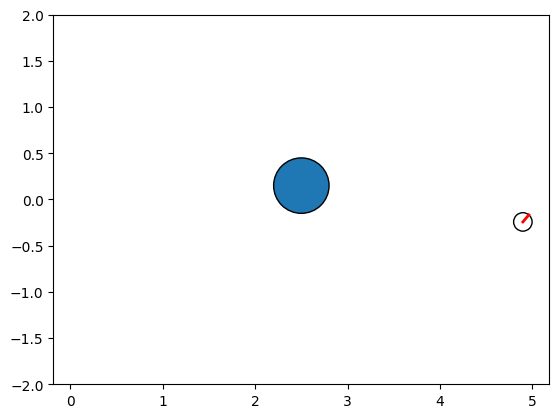

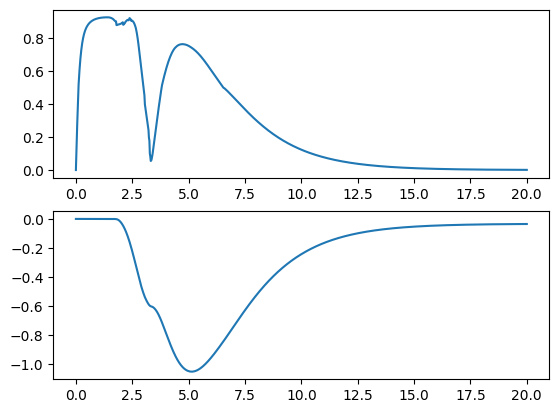

In [12]:
time_log = np.array(time_stamp)
x_log = np.array(x_log)
u_log = np.array(u_log)
fig = plt.figure()
ax = plt.axes()
ax.set_xlim(-1, 6)
ax.set_ylim(-2, 2)
plt.axis("equal")

robot = Circle(xy=x_log[0][:2], radius=args.r_, fill=False)
ax.add_artist(robot)
(line,) = ax.plot([], [], "r-", lw=2)


def update(frame):
    x, y, theta = x_log[frame]
    robot.center = (x, y)
    line_x = [x, x + args.r_ * np.cos(theta)]
    line_y = [y, y + args.r_ * np.sin(theta)]
    line.set_data(line_x, line_y)
    return robot, line


obstacle = Circle(xy=args.ev_pos[0], radius=args.d_, ec="k")
ax.add_artist(obstacle)

anim = FuncAnimation(fig, update, frames=501, interval=20, blit=True)

writer = PillowWriter(fps=50)  # fpsはフレームレートを指定
anim.save("CGMRES.gif", writer=writer)

fig2 = plt.figure()
ax1 = fig2.add_subplot(211)
ax2 = fig2.add_subplot(212)

ax1.plot(time_log, u_log[:, 0])
ax2.plot(time_log, x_log[:, 1])

plt.show()